In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score



In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [2]:
df=pd.read_csv("Building_Permits.csv",encoding = 'latin1' )
#df=pd.read_csv("Building_Permits.csv")
df.shape

/tmp/ipython-input-2167629709.py:1: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Building_Permits.csv",encoding = 'latin1' )


(198900, 43)

In [3]:
#repeating same EDA steps as before
df = df.drop(columns=["Street Number Suffix","Unit Suffix","Unit","Structural Notification","Voluntary Soft-Story Retrofit","TIDF Compliance","Site Permit","Description"])
df["Fire Only Permit"]=df["Fire Only Permit"].fillna("N")
df = df.dropna()
df.shape

(86824, 35)

In [4]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
categorical_df = df.select_dtypes(include=['object', 'category'])

small_cat_cols = [c for c in categorical_df if categorical_df[c].nunique() <= 10]
large_cat_cols = [c for c in categorical_df if categorical_df[c].nunique() > 10]

encoder = OneHotEncoder(sparse_output=False, drop='first')
small_encoded = encoder.fit_transform(categorical_df[small_cat_cols])
small_encoded_df = pd.DataFrame(
    small_encoded,
    columns=encoder.get_feature_names_out(small_cat_cols)
)

ord_enc = OrdinalEncoder()
large_encoded = ord_enc.fit_transform(categorical_df[large_cat_cols])
large_encoded_df = pd.DataFrame(
    large_encoded,
    columns=large_cat_cols
)

final_df = pd.concat(
    [numeric_df.reset_index(drop=True),
     small_encoded_df,
     large_encoded_df],
    axis=1
)

In [5]:
# CLASSIFICATION (Current Status)

current_status_cols = [col for col in final_df.columns if col.startswith("Current Status_")]
XC = final_df.drop(columns=current_status_cols)
#XC = final_df.drop(columns=["Current Status"])

scaler = StandardScaler()
XC_scaled = scaler.fit_transform(XC)

pca1 = PCA(n_components=0.95)
XC_pca = pca1.fit_transform(XC_scaled)
print(XC_pca.shape)

(86824, 22)


In [ ]:
#test a range of K to find optimal one
k_range = list(range(2, 6))

silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(XC_pca)
    silhouette_avg = silhouette_score(XC_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}, the silhouette score is {silhouette_avg:.5f}")

optimal_k_index = np.argmax(silhouette_scores)
optimal_k = k_range[optimal_k_index]
print(f"The optimal number of clusters (k) is: {optimal_k}")

For k=2, the silhouette score is 0.32559
For k=3, the silhouette score is 0.12456
For k=4, the silhouette score is 0.14752
For k=5, the silhouette score is 0.16491
The optimal number of clusters (k) is: 2


In [ ]:
#applying K-Means Clustering
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(XC_pca)
kmeans_centroids = kmeans_model.cluster_centers_

print(f"Centroids: {kmeans_centroids}")
silhouette_kmeans = silhouette_score(XC_pca, cluster_labels)
print(f"\nSilhouette Score: {silhouette_kmeans:.5f}")

Centroids: [[-4.70523205e+00 -3.68796192e-02  3.61938933e-01  3.10806636e-01
   3.29375971e-01  1.93574011e-01 -2.01733300e-02  1.77101806e-02
   4.61416835e-02  5.86763206e-02 -1.80054257e-01 -3.00353583e-02
  -6.38551849e-02  5.04565135e-04 -6.31220482e-02  1.19055472e-01
   1.07216556e-01  2.02965045e-01  1.56383532e-02 -3.12537984e-02
  -1.23324912e-02  5.76829606e-02]
 [ 1.45145648e+00  1.13765191e-02 -1.11649884e-01 -9.58767394e-02
  -1.01604954e-01 -5.97131556e-02  6.22301096e-03 -5.46318569e-03
  -1.42336541e-02 -1.81003030e-02  5.55426206e-02  9.26522113e-03
   1.96978642e-02 -1.55646805e-04  1.94717083e-02 -3.67258904e-02
  -3.30738555e-02 -6.26100748e-02 -4.82407432e-03  9.64108205e-03
   3.80429151e-03 -1.77938742e-02]]

Silhouette Score: 0.32559


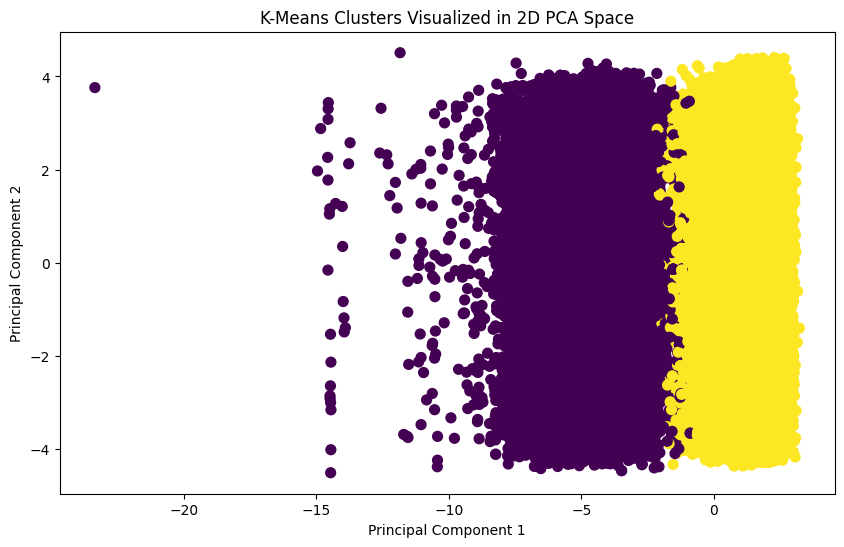

In [ ]:
#PCA for visualization
pca_viz = PCA(n_components=2)

X_viz = pca_viz.fit_transform(XC_pca)

plt.figure(figsize=(10, 6))
plt.scatter(X_viz[:, 0], X_viz[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clusters Visualized in 2D PCA Space")
plt.savefig('k_cluster_visualization_2d.png')

In [ ]:
#applying Agglomerative Clustering

# taking a random sample of the data
sample_size = min(10000, XC_pca.shape[0])
np.random.seed(42)
sampled_indices = np.random.choice(XC_pca.shape[0], size=sample_size, replace=False)
XC_pca_sample = XC_pca[sampled_indices]

optimal_k = 2
agglomerative = AgglomerativeClustering(n_clusters=optimal_k)
agglomerative_labels = agglomerative.fit_predict(XC_pca_sample)

print(f"Agglomerative Clustering applied to a sample of {sample_size} data points.")

silhouette_agg = silhouette_score(XC_pca_sample, agglomerative_labels)
print(f"\nSilhouette Score: {silhouette_agg:.5f}")

Agglomerative Clustering applied to a sample of 10000 data points.

Silhouette Score: 0.97322


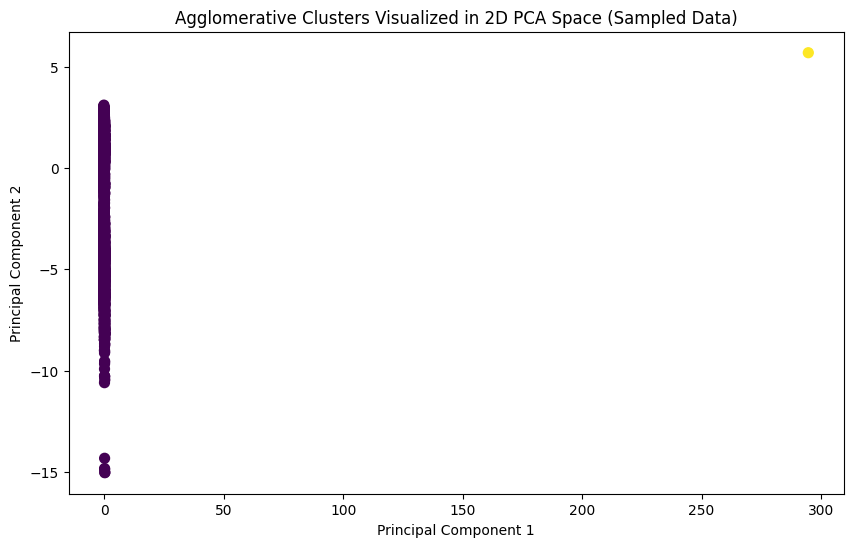

In [ ]:
#PCA for visualization
pca_viz2 = PCA(n_components=2)

X_viz2 = pca_viz2.fit_transform(XC_pca_sample)

plt.figure(figsize=(10, 6))
plt.scatter(X_viz2[:, 0], X_viz2[:, 1], c=agglomerative_labels, cmap='viridis', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Agglomerative Clusters Visualized in 2D PCA Space (Sampled Data)")
plt.savefig('a_cluster_visualization_2d.png')

In [ ]:
# applying Spectral Clustering, a type of HCA

spectral = SpectralClustering(n_clusters=optimal_k, random_state=42, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(XC_pca_sample)

print(f"Spectral Clustering applied with {optimal_k} clusters.")

silhouette_spectral = silhouette_score(XC_pca_sample, spectral_labels)
print(f"\nSilhouette Score: {silhouette_spectral:.5f}")

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral Clustering applied with 2 clusters.

Silhouette Score: 0.34105


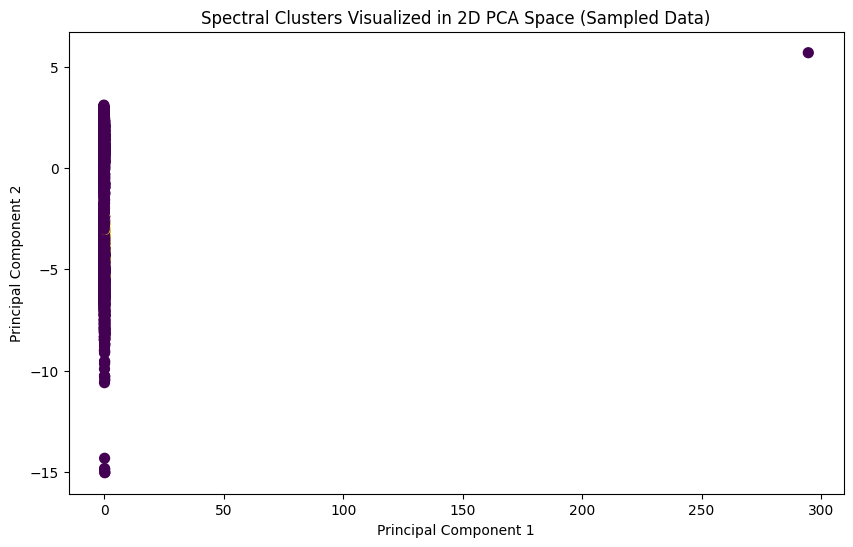

In [ ]:
pca_viz3 = PCA(n_components=2)

X_viz3 = pca_viz3.fit_transform(XC_pca_sample)

plt.figure(figsize=(10, 6))
plt.scatter(X_viz3[:, 0], X_viz3[:, 1], c=spectral_labels, cmap='viridis', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Spectral Clusters Visualized in 2D PCA Space (Sampled Data)")
plt.savefig('s_cluster_visualization_2d.png')

In [ ]:
#applying CATBOOST

X = df.drop('Current Status', axis=1)
Y = df['Current Status']

sample_size1 = min(10000, X.shape[0])
np.random.seed(42)
sampled_indices1 = np.random.choice(X.shape[0], size=sample_size1, replace=False)
X_sample = X.iloc[sampled_indices1]
Y_sample = Y.iloc[sampled_indices1]

X_train, X_test, Y_train, Y_test = train_test_split(X_sample, Y_sample, test_size=0.2,random_state=42)

categorical_features_names = [col for col in X.columns if X[col].dtype == 'object']

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    loss_function='MultiClass',
    random_seed=42,
    verbose=0,
    cat_features=categorical_features_names
)

cat_model.fit(X_train, Y_train)

y_pred_cat = cat_model.predict(X_test)
y_pred_cat = y_pred_cat.flatten()

accuracy_cat = accuracy_score(Y_test, y_pred_cat)
f1_cat = f1_score(Y_test, y_pred_cat, average='macro', zero_division=0)

print("\n----------CatBoost Performance----------")
print(f"Test Accuracy: {accuracy_cat:.5f}")
print(f"Test F1: {f1_cat:.5f}")


----------CatBoost Performance----------
Test Accuracy: 0.99850
Test F1: 0.33308


In [13]:
#LDA and PCA for comparison
current_status_cols = [col for col in final_df.columns if col.startswith("Current Status_")]
XC = final_df.drop(columns=current_status_cols)
#XC = final_df.drop(columns=["Current Status"])
YC = df["Current Status"]

XC_train, XC_test, YC_train, YC_test = train_test_split(
    XC, YC, test_size=0.2, random_state=42
)

scaler = StandardScaler()
XC_train_scaled = scaler.fit_transform(XC_train)
XC_test_scaled  = scaler.transform(XC_test)

lda = LinearDiscriminantAnalysis()
XC_train_lda = lda.fit_transform(XC_train_scaled, YC_train)
XC_test_lda  = lda.transform(XC_test_scaled)

pca1 = PCA(n_components=0.95)
XC_train_pca = pca1.fit_transform(XC_train_scaled)
XC_test_pca  = pca1.transform(XC_test_scaled)

In [14]:
#Comparing Results Before & After dimensionality reduction
modelNB1 = GaussianNB()
modelNB1.fit(XC_train_pca,YC_train)
y_pred_NB1 = modelNB1.predict(XC_test_pca)
Accuracy_NB1= accuracy_score (YC_test,y_pred_NB1)
print("NAIVE BAYES")
print("Performance using PCA ")
print(f"Accuracy: {Accuracy_NB1:.5f}")
precision_NB1  = precision_score(YC_test,y_pred_NB1,average='weighted')
print(f"Precision: {precision_NB1:.5f}")
print("")

modelNB2 = GaussianNB()
modelNB2.fit(XC_train_lda,YC_train)
y_pred_NB2 = modelNB2.predict(XC_test_lda)
Accuracy_NB2= accuracy_score (YC_test,y_pred_NB2)
print("Performance using LDA ")
print(f"Accuracy: {Accuracy_NB2:.5f}")
precision_NB2 = precision_score(YC_test,y_pred_NB2,average='weighted')
print(f"Precision: {precision_NB2:.5f}")
print("")

modelNB3 = GaussianNB()
modelNB3.fit(XC_train_scaled,YC_train)
y_pred_NB3 = modelNB3.predict(XC_test_scaled)
print("Performance without any Dimensionality Reduction")
Accuracy_NB3= accuracy_score (YC_test,y_pred_NB3)
print(f"Accuracy: {Accuracy_NB3:.5f}")
precision_NB3= precision_score(YC_test,y_pred_NB3,average='weighted')
print(f"Precision: {precision_NB3:.5f}")


NAIVE BAYES
Perfomance using PCA 
Accuracy: 0.71080
Precision: 0.99813

Perfomance using LDA 
Accuracy: 0.99033
Precision: 0.99850

Perfomance without any Dimensionality Reduction
Accuracy: 0.04722
Precision: 0.99902
